#Generative adversarial networks in wood anatomy 



# About

This notebook was created to enable users to experiment with the model created in the paper entitled "**Creating high-resolution microscopic cross-section images of hardwood species using generative adversarial networks**". 

The full paper can be found at: [link text](https://)

The model and code can found at: https://github.com/LignumResearch/stylewood-model-usage.

We have selected the StyleGAN model that is presented in the paper and created an environment in which users can freely use the model even if they do not have access to a GPU. This notebook should be used on Google Colaboratory, which requires no setup and provides free GPU access.  

This Google Colab is divided into:

**1) Before we begin.**

**2) Installing pre-requisites.**

**3) Using the StyleGAN model in this notebook.**

**4) Using a web application for generating images.**

  



---



# Before we begin
Since not all users may be familiar with Google Collab, we have prepared a video tutorial that explains how to use this notebook. 

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/6qYDhWaJL5c" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

For more information on how to use Google Collab, we recommend visiting the [introductory notebook](https://colab.research.google.com/notebooks/intro.ipynb).

You will notice that most code cells have `%%capture` at the first line. This is to avoid showing the output of the cells. If you are having problems, and need to debug what is happening, we recommend you remove the lines that have this tag.

The "**Installing Pre-requisites**" section contains all the code for setting up the packages and files necessary to run/use the model. 

The "**Using the model**" section contains a basic use case of the model to generate random images.

The "**Using the web app**" section contains steps that will take you to a menu-driven and user-friendly interface to generate images.



---



# Installing pre-requisites

We begin by installing the correct TensorFlow version. StyleGAN was implemented using an older version of TensorFlow and it used deprecated functionalities. To that end, TensorFlow GPU 1.15 is required and installed in the next line.
**It can take a couple of minutes to install this package. This step is necessary for running the model and the web app.**

In [2]:
%%capture
!pip install tensorflow-gpu==1.15

 The next couple of cells will download and prepare the steps for running the StyleGAN model and the web app.

In [3]:
%%capture
!gdown https://drive.google.com/uc?id=1Ju49LYdz3yJWIQAiwhGaZjOTdvfAfrUG

In [4]:
%%capture
!sudo unzip Collab.zip -d /content

In [5]:
%%capture
!cp -R /content/Collab/* /content

Since not all users may feel very comfortable changing model parameters in code, we used Streamlit to develop a web application that serves as a User Interface. We will talk more about this in later sections. 

**This step is only necessary if you plan to run the web app.**

In [6]:
%%capture
!pip install -q streamlit

You can run the web application with Collab and access it via a public URL with NGrok. The next few lines are for downloading and installing ngrok. 

**This step is only necessary if you plan to run the web app.**

In [7]:
%%capture
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [8]:
%%capture
!unzip ngrok-stable-linux-amd64.zip



---



# Using the StyleGAN model in this notebook
Next, you can use the model to generate random pictures on this notebook, or access the web application we've prepared. 

**If you want to skip ahead to the "Using web application" section, you don't need the code cells in this topic.**

We begin by loading the model. This will prepare and load the model we created using StyleGAN. 

In [9]:
%%capture
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

# Loading the model
tflib.init_tf()
Gs = pickle.load(open("/content/results/image_generation.pkl", "rb"))

Next, we set model's parameters. We also define a new random state to generate a new latent vector everytime. The latent vector is the randomly generated input for our model. Each time you re-run this code cell, the next code cell will generate a completely different image.

In [10]:
trunc_psi = 0.7                                 # According to documentation: Style strength multiplier for the truncation trick. Generally between 0 and 1, or None to disable.
trunc_cutoff = 8                                # According to documentation: Number of layers for which to apply the truncation trick. None to disable.
randomize_input = False                         # Randomizes the order of the values in the latent vector. If this is True, the same latent vector may generate a different image.
rnd = np.random.RandomState(None)               # For generating random latent vector.
latents = rnd.randn(1, Gs.input_shape[1])       # Generates [1, 512] array filled with values from standard normal distribution.
#latents = np.zeros((50, Gs.input_shape[1]))    # Latent vector can also be filled manually to produce a specific image (if randomization of inputs/noise is off). You can uncomment this line to test this.

Next, we use these parameters to generate a new image. 

In [11]:
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
	
new_image = Gs.run(latents, None, truncation_psi=trunc_psi, randomize_noise=False, output_transform=fmt)

You can save this image by right-clicking on it and selecting "Save Image As...". To generate a new picture, you can run the last two code cells (parameter selection and re-run model). 

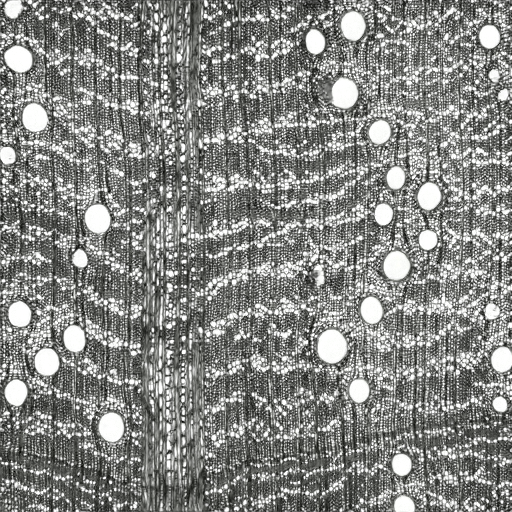

In [12]:
display(PIL.Image.fromarray(new_image[0], 'RGB'))

### *Generating Smooth Transitions*



 

To visualize how small changes in the latent space reflect in the images, we have implemented a script for generating an animation that presents a transition between two images. We begin by initializing the latent vector for generating two completely different images.

### Initial Image

Feel free to re-run this chunk of code until you find an image you like.

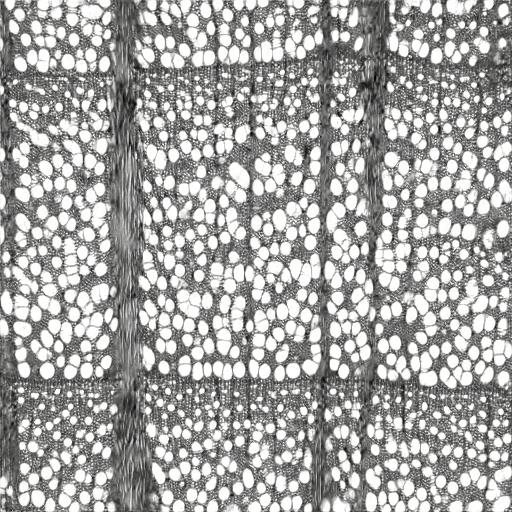

In [13]:
# Initializing latent vector
rnd = np.random.RandomState(None)
latents_initial_image = rnd.randn(1, Gs.input_shape[1])
transition_latent = latents_initial_image.copy() # Copying initial latent vector for later use

# Generating image for latent vector
initial_image = Gs.run(latents_initial_image, None, randomize_noise=False, output_transform=fmt)

# Diplaying the image
display(PIL.Image.fromarray(initial_image[0], 'RGB'))

### Final Image
You can also re-run this chunk until you find an image you like.

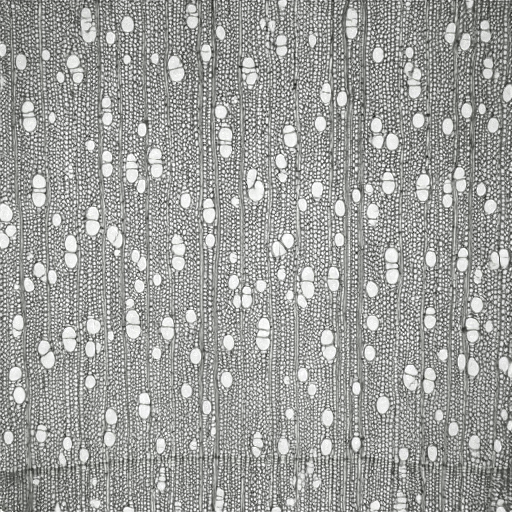

In [14]:
# Initializing latent vector
rnd = np.random.RandomState(None)
latents_final_image = rnd.randn(1, Gs.input_shape[1])

# Generating image for latent vector
final_image = Gs.run(latents_final_image, None, randomize_noise=False, output_transform=fmt)

# Diplaying the image
display(PIL.Image.fromarray(final_image[0], 'RGB'))

### Producing Transition
The two selected images can be used to produce an animation with the transition. We do this by calculating the difference between the two latent vectors. We can divide the vector that contains the difference by an integer  `x` that determines the number of intermediary steps to take. This produces a vector that can be added to the initial latent vector `x` times to arrive to produce the final latent vector (or at least something very close). For each step, we produce and save the image. 

Feel free to change the number of steps taken, but keep in mind that a very large number will generate a lot of images. 

In [15]:
# List used to accumulate the generated images.
imgs = []
img_array = []

# Inserting initial image to list of images
imgs.append(PIL.Image.fromarray(initial_image[0], 'RGB'))
img_array.append(initial_image[0])

# Number of images to produce for the transtion (we called it x above).
steps = 100

# Mahattan distance between transition latent vector (which is equivalent to initial latent vector) and final latent vector
print("Initial manhattan distance:", np.sum(np.abs(latents_initial_image - latents_final_image)))

# Producing the intermediary images
for i in range(0,steps):
    # Incrementing values in latent vector for next step
    transition_latent += ((latents_final_image - latents_initial_image)/steps)
    
    # Producing images for current step
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(transition_latent, None, randomize_noise=False, output_transform=fmt)
    
    # Pushing image to end of imgs list.
    imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    img_array.append(images[0])

# Inserting final image to list of images
imgs.append(PIL.Image.fromarray(final_image[0], 'RGB'))
img_array.append(final_image[0])

# Mahattan distance between transition latent vector (which should be very close to the final latent vector) and final latent vector
print("Final manhattan distance:", np.sum(np.abs(transition_latent - latents_final_image)))

Initial manhattan distance: 609.4599451345393
Final manhattan distance: 8.108266662254504e-13


We can then use the accumulated images to produce and display the transition as a GIF.

In [16]:
imgs[0].save('transition.gif', save_all=True, append_images=imgs, loop = 0)

To view the GIF, you must open the files in the instance running this notebook. This can be done by click on "Files" (bar on the left side of the screen) and clicking on the GIF. Generally, loading the GIF takes a minute or two.

![](https://cdn.kapwing.com/final_60eb824e82839e0109d2b1d0_333116.gif)

# Using the web app


**We highly recommend you watching the two video below. They provide a concise tutorial on how to use the web application.**

In [17]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/rtU-PI-Lbxo" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/KQ0taZxkPKk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

To access the web application, we begin by establishing a tunnel with ngrok. This will be used to establish a link where we can access the web application.

This is needed because the streamlit code must be kept running on the notebook. If for some reason the the last code cell stops executing, the web application will stop working.

In [19]:
get_ipython().system_raw('./ngrok http 8501 &')

If running the next chunk of code generates an error, please re-run the last and the following chunks. This happens because Google Collab ran the code cell before the last chunk finished.

In [20]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: http://b82ed234d236.ngrok.io


We can run our web application using streamlit. This last code cell will need to be kept running, otherwise, the link will stop working. If that happens, execute these three last code cells to generate a new link and restart the application. After executing the last code cell, please click on the link above. Remember that this link might break after a few minutes, so you might need to repeat this process. Also, the generated link will only work for one user at a time. 

In [21]:
%%capture
!streamlit run /content/Collab/webapp.py

Since we are using free services, there are some limitations to look out for. This notebook will stop running after a while, and with that, the web application will stop working. Another limitation is the number of requests that can be made to ngrok at a time. Updating the page too quickly will end up exceeding the limit of requests, and the images will stop rendering. 

There are two ways to fix this. 
- The prefered method is to wait a minute until you make new requests. After 60 seconds, more requests can be made for the same connection, and this should fix any problems. 
- The second alternative is to execute the last three code cells to generate a new access link. If this still doesn't fix it, we recommend restarting the notebook ad re-executing all code cells. 

## Credits and Rerences
 For the paper, we trained StyleGAN to generate synthetic microscopic cross sections of hardwood species. 

- A Style-Based Generator Architecture for Generative Adversarial Networks. Tero Karras (NVIDIA), Samuli Laine (NVIDIA), Timo Aila (NVIDIA). [https://arxiv.org/abs/1812.04948](https://arxiv.org/abs/1812.04948). [StyleGAN — Official TensorFlow Implementation](https://github.com/NVlabs/stylegan).

To train StyleGAN, we used a dataset containing identified microscopic cross-sectional images of hardwoods species by the XDD research team.

- SUGIYAMA, Junji, HWANG, Sung Wook, ZHAI, ShengCheng, KOBAYASHI, Kayoko, KANAI, Izumi, KANAI, Keiko. [Xylarium Digital Database for Wood Information Science and Education](http://hdl.handle.net/2433/250016).

The complete set of references can be found in our paper. 